# Logistic regression example
Exemple adapted from:
https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

We will use Logistic Regression to calculate the probability for a student to pass an exam given the number of hours of study and number of hours slept:

$$p(\text{passed}) = \sigma(w_0 + w_1 \cdot \text{hours studied} + w_2 \cdot \text{hours slept})$$

### Initialize

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize # for fit
%matplotlib inline
rng = np.random.RandomState(0)

In [2]:
print(matplotlib.__version__)

3.5.1


## 1. Read data

We first start to read a `cvs` file containing, for each student, the number of hours studied and slept (=the `features`) and the result (=the `labels`) of the exam: 0 (Failed) or 1 (passed).

a) Separate the sample in student that passed the exam and student that failed the exam:
```python
labels = ...
student_passed = ...
student_failed = ...
```

b) Show on a figure for each student the number of hours slept as a function of the number of hours studied. Use a blue marker for students that passed and a red marker for those who failed.

   Studied      Slept   Passed
[[0.     0.     0.    ]
 [7.4517 1.0466 0.    ]
 [4.5133 0.8208 0.    ]
 [7.1874 8.4608 1.    ]
 [0.     6.8263 0.    ]
 [0.379  4.039  0.    ]
 [9.7729 6.9286 1.    ]
 [6.5881 0.1785 1.    ]
 [2.5981 3.0238 0.    ]
 [3.9293 2.9235 1.    ]]


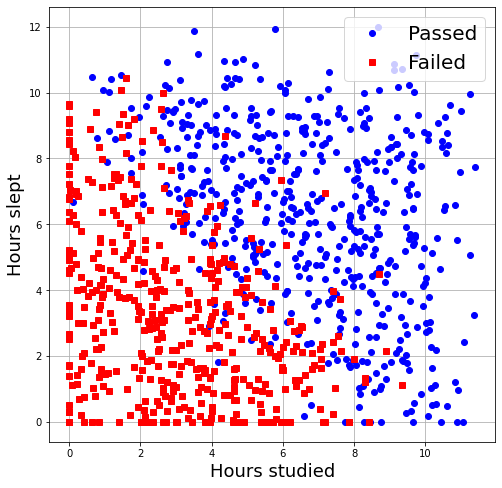

In [3]:
# Load and read file
from numpy import genfromtxt
my_data = genfromtxt('data/data_student_exams.csv', delimiter=',')
print('%10s %10s %8s'% ('Studied', 'Slept', 'Passed'))

# Print first 10 entries
print(my_data[:10,:])

# Get data labels
labels=my_data[:,2]

# Separate sample in students that pass and that fail
student_passed = my_data[labels>0]
student_failed = my_data[labels<1]

# Show data
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(student_passed[:,0],student_passed[:,1],'bo',lw=1,label='Passed')
axes.plot(student_failed[:,0],student_failed[:,1],'rs',lw=1,label='Failed')
axes.set_xlabel('Hours studied',fontsize=18)
axes.set_ylabel('Hours slept',fontsize=18)
axes.grid()
plt.legend(loc='upper right',fontsize=20)

## 2. Separate data in train and test sample

a) You'll note below that we add a column of "1" to the vector of features ${\bf x}$. Why do we do that ? The vector ${\bf x}$ is redefined as ${\bf x^*}$:
$${\bf x} \rightarrow {\bf x^*}$$

b) Separate the sample in two: the first 500 entries for training and the remaining 500 entries for testing.
```python
features_train = ...
labels_train = ...
features_test = ...
labels_test = ...
```


In [4]:
# Data features: [1, studied, slept]
features = my_data[:,0:2]
bias = np.ones(shape=(len(features),1))
features = np.append(bias, features, axis=1)

# N examples for train and test
N=500

# Train dataset
features_train = features[:N,:]
labels_train = labels[:N]

# Test dataset
features_test = features[N:2*N,:]
labels_test = labels[N:2*N]

## 3. Sigmoid function

For training the Logistic Regression we'll need the sigmoid function and its derivative

a) Write two functions, `sigmoid(x)` and `dsig(x)` that returns, respectively $\sigma(x)$ and $\frac{\text{d} \sigma}{\text{d} x}(x)$.

b) Represent graphically both functions on the same figure.

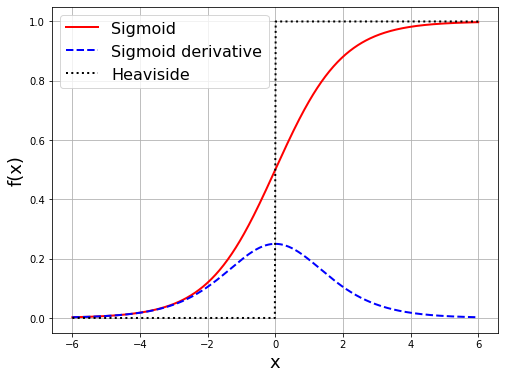

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def dsig(x):
    return sigmoid(x)*(1-sigmoid(x))

# Plot sigmoid function
x = np.linspace(-6,6,500)
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(x,sigmoid(x),'r-',lw=2,label='Sigmoid')
axes.plot(x,dsig(x),'b--',lw=2,label='Sigmoid derivative')
axes.plot(x,np.heaviside(x,0),'k:',lw=2,label='Heaviside')
axes.set_xlabel('x',fontsize=18)
axes.set_ylabel('f(x)',fontsize=18)
axes.grid()
plt.legend(loc='upper left',fontsize=16)

## 4. Building a predictive model

The predictive model for a feature ${\bf x}$ is given by the function:

$$f({\bf x}) = \sigma \left( w_0 + \sum_{i=1}^D w_i x_i \right) = \sigma \left(\sum_{i=0}^D w_i x^*_i \right)$$

The cost function used in the Logistic Regression is the cross-entropy:

$$E({\bf w}) = - \frac{1}{N}\sum_{j=1}^N t_j \log( f({\bf x_j})) + (1-t_j) \log( 1 - f({\bf x_j}))$$

The gradient of the cross-entropy function is:
$$
\vec{\nabla} E({\bf w}) = \frac{1}{N}\sum_{j=1}^N \left[ f({\bf x_j}) - t_j \right] {\bf x^*_j} \rightarrow
\begin{cases}
\frac{\partial E({\bf w})}{\partial w_0} = \frac{1}{N}\sum_{j=1}^N \left[ f({\bf x_j}) - t_j \right] \\\\
\frac{\partial E({\bf w})}{\partial w_1} = \frac{1}{N}\sum_{j=1}^N \left[ f({\bf x_j}) - t_j \right] x_{j1} \\
\vdots \\
\frac{\partial E({\bf w})}{\partial w_D} = \frac{1}{N}\sum_{j=1}^N \left[ f({\bf x_j}) - t_j \right] x_{jD}
\end{cases}$$

### Functions needed for training

Let's define the functions needed to train the algorithm. Look at all the functions below and explain for each what they do.


In [6]:
def predict(features, weights):
    '''
    Returns 1D array of probabilities
    that the class label == 1
    '''
    z = np.dot(features, weights)
    return sigmoid(z)

def cost_function(features, labels, weights):
    '''
    Cross-Entropy cost function

    Features:(100,3)
    Labels: (100,1)
    Weights:(3,1)
    Returns 1D matrix of predictions
    Cost = sum ( labels*log(predictions) + (1-labels)*log(1-predictions) ) / len(labels)
    '''
    observations = len(labels)

    predictions = predict(features, weights)

    #Take the error when label=1
    class1_cost = -labels*np.log(predictions)

    #Take the error when label=0
    class2_cost = (1-labels)*np.log(1-predictions)

    #Take the sum of both costs
    cost = class1_cost - class2_cost

    #Take the average cost
    cost = cost.sum()/observations

    return cost

def update_weights(features, labels, weights, lr):
    '''
    Gradient Descent

    Features:(100, 3)
    Labels: (100, 1)
    Weights:(3, 1)
    '''
    N = len(features)

    #1 - Get Predictions
    predictions = predict(features, weights)

    #2 Transpose features from (100, 3) to (3, 100)
    # So we can multiply w the (100,1)  cost matrix.
    # Returns a (3,1) matrix holding 3 partial derivatives --
    # one for each feature -- representing the aggregate
    # slope of the cost function across all observations
    gradient = np.dot(features.T,  predictions - labels)
    
    #3 Take the average cost derivative for each feature
    gradient /= N

    #4 - Multiply the gradient by our learning rate
    gradient *= lr
    
    #5 - Subtract from our weights to minimize cost
    weights -= gradient

    return weights

def train(features, labels, weights, lr, iters):
    """
    Training using gradient descent
    """
    cost_history = []

    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)

        # Log Progress
        #if i % 1000 == 0:
        #    print("iter: "+str(i) + " cost: "+str(cost))

    return weights, cost_history

## 5. Training

Calculate the weights with gradient descent for 20000 steps. Plot cost function evolution.

Weights: [-12.6460271    1.48600406   1.22283211]


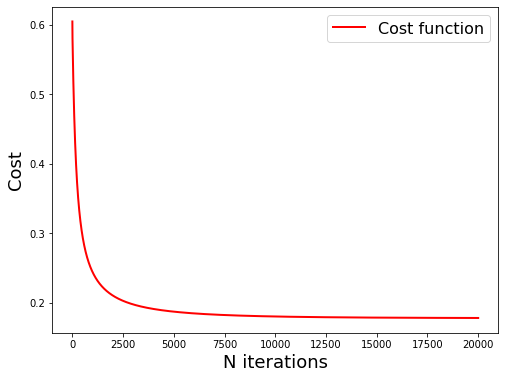

In [7]:
# Initialize weights
weights = np.array([0.0,0.0,0.0])

# Calculate weights with gradient descent
Niter=20000
learning_speed = 0.1
weights_new, cost_history = train(features_train, labels_train, weights, learning_speed,Niter)
print('Weights:',weights_new)

# Plot cost function evolution
x = np.linspace(1,Niter,Niter)
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(x,cost_history,'r-',lw=2,label='Cost function')
axes.set_xlabel('N iterations',fontsize=18)
axes.set_ylabel('Cost',fontsize=18)
#axes.grid()
plt.legend(loc='upper right',fontsize=16)

## 6. Accuracy of predictions

a) Determine the predicted probabilities for the training dataset. Deduce the predicted labels (0 or 1).

b) Calculate how correct predictions are: for this you can compare the predicted labels to true labels and divide by the total number of lables. 

c) Same questions for the test dataset. Is there any overtraining ?

In [8]:
def accuracy(predicted_labels, actual_labels):
    """
    Accuracy measures how correct our predictions were: compare predicted labels 
    to true labels and divide by the total.
    """
    diff = predicted_labels - actual_labels
    return 1.0 - np.sum(np.abs(diff))/len(diff)

In [9]:
# train dataset
predicted_probabilities_train = predict(features_train, weights)
predicted_labels_train = np.round(predicted_probabilities_train)
accuracy_prediction_train = accuracy(predicted_labels_train, labels_train)
print('Accuracy of predictions (train dataset): %.3f' % accuracy_prediction_train)

# test dataset
predicted_probabilities_test = predict(features_test, weights)
predicted_labels_test = np.round(predicted_probabilities_test)
accuracy_prediction_test = accuracy(predicted_labels_test, labels_test)
print('Accuracy of predictions (test dataset): %.3f' % accuracy_prediction_test)

Accuracy of predictions (train dataset): 0.924
Accuracy of predictions (test dataset): 0.890


## 7. Show results (with probabilities)

a) Show on a figure for each student the number of hours slept as a function of the number of hours studied. Use markers with a color depending on the probability value of the student to pass the exam: from dark red for low probabilities to dark blue for high probabilities.

b) Add a line showing the decision boundary separing both classes.  Hint: this line correspond to points for which p(accepted)=0.5, that is, students for which the weighted sum is such that $(w_0 + w_1 \cdot x_1 + w_2 \cdot x_2)=0$.

--> If the weighted sum of inputs is greater than zero, the predicted class is 1 and vice-versa. So the decision boundary separating both the classes can be found by setting the weighted sum of inputs to 0, that is
$$(w_0 + w_1 x_1 + w_2 x_2)= 0 $$
Hence:
$$x_2 = -\frac{w_0 + w_1 x_1}{w_2}$$


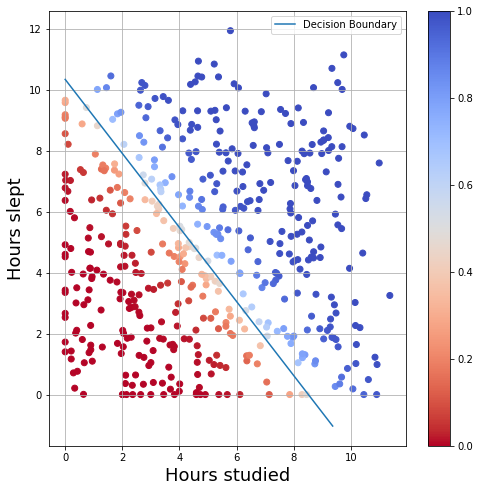

In [10]:
# Decision boundary
x_values = [np.min(features_test[:, 1]), np.max(features_test[:, 1]-2)]
y_values = - (weights[0] + np.dot(weights[1], x_values)) / weights[2]

# Show plot with marker color depending on probability
plt.figure(figsize=(8,8))
plt.scatter(features_test[:,1],features_test[:,2],c=predicted_probabilities_test,cmap='coolwarm_r',vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('Hours studied',fontsize=18)
plt.ylabel('Hours slept',fontsize=18)
plt.grid()
plt.plot(x_values, y_values, label='Decision Boundary')
plt.legend(loc='upper right',fontsize=10)
plt.show()

In [11]:
y_values

array([10.34158901, -1.03258138])

## 8. Predicted probability distributions

Show the distribution of predicted probabilities for student that passed or failed the exam, for both train and test dataset.

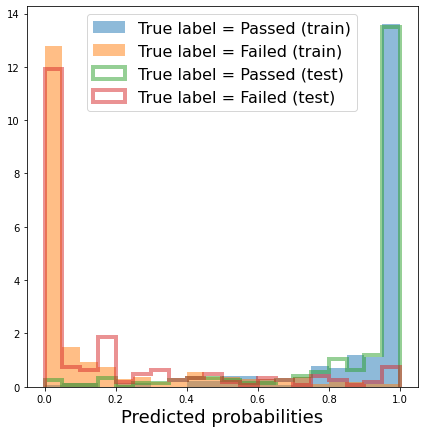

In [12]:
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(predicted_probabilities_train[labels_train>0.5], range=(0,1), bins=20, alpha=0.5, label='True label = Passed (train)', density=1)
plt.hist(predicted_probabilities_train[labels_train<0.5], range=(0,1), bins=20, alpha=0.5, label='True label = Failed (train)', density=1)
plt.hist(predicted_probabilities_test[labels_test>0.5], range=(0,1), bins=20, alpha=0.5, label='True label = Passed (test)', density=1,histtype='step',lw=4)
plt.hist(predicted_probabilities_test[labels_test<0.5], range=(0,1), bins=20, alpha=0.5, label='True label = Failed (test)', density=1,histtype='step',lw=4)
plt.xlabel('Predicted probabilities',fontsize=18)
plt.legend(loc='upper center',fontsize=16)

## 9. Confusion matrix

See below how to construct a confusion matrix. 

The `threshold` value corresponds to the probability threshold over which student are labelled as Passing the exam.

Change the threshold value and see how the values in the confusion matrix change.

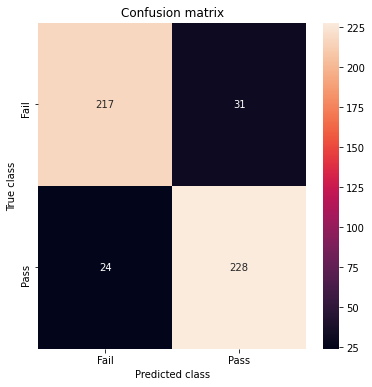

False positive rate = 12.50 %
True positive rate = 90.48 %


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#print(sns.__version__)

LABELS = ["Fail","Pass"]

threshold = 0.5

y_pred = [1 if e > threshold else 0 for e in predicted_probabilities_test]
conf_matrix = confusion_matrix(labels_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

TN = conf_matrix[0,0] # True Negative (Fail -> Fail)
FP = conf_matrix[0,1] # False Positive (Fail -> Pass)
FN = conf_matrix[1,0] # False Negative (Pass -> Fail)
TP = conf_matrix[1,1] # True Positive (Pass -> Pass)
print('False positive rate = %.2f %%' % (FP/(FP+TN)*100))
print('True positive rate = %.2f %%' % (TP/(TP+FN)*100))

## ROC Curve

A more global way to assess the performance of the algorithm is to construct the ROC curve ("Receiver Operating Characteristic"). The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

Look at the code below.

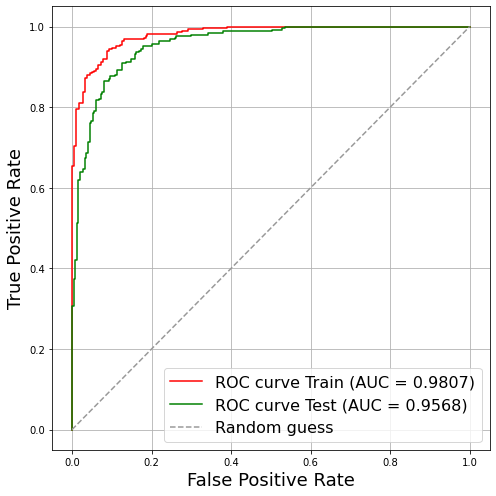

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

#target = np.concatenate((np.zeros(x_train.shape[0]),np.ones(x_test.shape[0])))
#scores = np.concatenate((norm_train,norm_test))  

plt.figure(figsize=(7, 7))
# Train set                   
fp, vp, thresholds = roc_curve(labels_train,predicted_probabilities_train,pos_label=1,drop_intermediate='False')
roc_auc = auc(fp, vp)
plt.plot(fp,vp,color='red',label='ROC curve Train (AUC = %0.4f)'%(roc_auc))
# Test set                   
fp, vp, thresholds = roc_curve(labels_test,predicted_probabilities_test,pos_label=1,drop_intermediate='False')
roc_auc = auc(fp, vp)
plt.plot(fp,vp,color='green',label='ROC curve Test (AUC = %0.4f)'%(roc_auc))
deprecated
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='Random guess')
plt.grid()
plt.legend(loc="best",fontsize=16)
plt.tight_layout()
#plt.savefig("images/ROC.png")

## Optional: generate new data